### Import libraries

In [1]:
import psycopg2
import json
import requests
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

#### Loading the JSON data 
- This code retrieves JSON data from a specified URL and writes it to a local file named "airlines.json".
- It ensures the request is successful before extracting and saving the JSON data.

In [2]:
# URL of the JSON data
url = "https://think.cs.vt.edu/corgis/datasets/json/airlines/airlines.json"
response = requests.get(url)
if response.status_code == 200:
    # Get the JSON data from the response
    json_data = response.json()

# Write the json data 
with open('airlines.json','w') as json_file:
     json_file.write(response.text)

### Create connection and database

In [3]:
#establishing the connection
conn = psycopg2.connect(
   database="postgres", 
   user='postgres',
   password='password', 
   host='127.0.0.1',
   port= '5432'
)
conn.autocommit = True

#Creating a cursor object using the cursor() method to act as interface to our database
cursor = conn.cursor()

In [4]:
#Preparing query to create a database
sql = '''CREATE database mydb''';

#Creating a database
cursor.execute(sql)
print("Database created successfully........")

Database created successfully........


In [5]:
# query="""DROP DATABASE mydb"""
# cursor.execute(query)

### Creating tables  - airports, time and statistics.

In [6]:
airports_table="""CREATE TABLE IF NOT EXISTS airports (
    Code VARCHAR(3) PRIMARY KEY,
    Name VARCHAR(255)
);"""
# Creating the table
cursor.execute(airports_table)

In [7]:
time_table="""CREATE TABLE IF NOT EXISTS time (
    Label VARCHAR(10) PRIMARY KEY,
    Month INTEGER,
    Month_Name VARCHAR(20),
    Year INTEGER
);"""
# Creating the table
cursor.execute(time_table)

In [8]:
stats_table="""CREATE TABLE IF NOT EXISTS statistics (
   ID SERIAL PRIMARY KEY,
        Airport_Code VARCHAR(3) REFERENCES airports(Code),
        Time_Label VARCHAR(10) REFERENCES Time(Label),
        Delays_Carrier INT,
        Delays_Late_Aircraft INT,
        Delays_National_Aviation_System INT,
        Delays_Security INT,
        Delays_Weather INT,
        Carriers_Names TEXT,
        Carriers_Total INT,
        Flights_Cancelled INT,
        Flights_Delayed INT,
        Flights_Diverted INT,
        Flights_On_Time INT,
        Flights_Total INT,
        Minutes_Delayed_Carrier INT,
        Minutes_Delayed_Late_Aircraft INT,
        Minutes_Delayed_National_Aviation_System INT,
        Minutes_Delayed_Security INT,
        Minutes_Delayed_Weather INT,
        Minutes_Delayed_Total INT
);"""
# Creating the table
cursor.execute(stats_table)

### Data insertion to tables
- This function inserts data into three tables: 'Airports', 'Time', and 'Statistics'.
- For each entry in the input data, it extracts relevant information and inserts it into the respective tables.
- It uses the provided cursor and connection to execute SQL queries and commit changes to the database.

In [9]:
# Function to insert data into PostgreSQL database
def insert_data(data):
    """
    Insert data into the 'Airports', 'Time', and 'Statistics' tables in the database.
    For each entry in the input data, it extracts relevant information and inserts it into the respective tables.

    Args:
    - data (list): A list of dictionaries containing airlines data to be inserted.
    - cursor: The cursor object used to execute SQL queries.
    - conn: The connection object representing the database connection.

    Returns:
    - None
    """
    for entry in data:
        airport_data = (entry['Airport']['Code'], entry['Airport']['Name'])
        cursor.execute(""" INSERT INTO Airports (Code, Name)
        VALUES (%s, %s)
        ON CONFLICT DO NOTHING """, airport_data)
        
        time_data = (entry['Time']['Label'], entry['Time']['Month'], entry['Time']['Month Name'], entry['Time']['Year'])
        cursor.execute("""INSERT INTO Time (Label, Month, Month_Name, Year)
        VALUES (%s, %s, %s, %s)
        ON CONFLICT DO NOTHING""", time_data)

        statistics_data = ( entry['Airport']['Code'], entry['Time']['Label'],
        entry['Statistics']['# of Delays']['Carrier'], entry['Statistics']['# of Delays']['Late Aircraft'],
        entry['Statistics']['# of Delays']['National Aviation System'], entry['Statistics']['# of Delays']['Security'],
        entry['Statistics']['# of Delays']['Weather'],
        entry['Statistics']['Carriers']['Names'], entry['Statistics']['Carriers']['Total'],
        entry['Statistics']['Flights']['Cancelled'], entry['Statistics']['Flights']['Delayed'],
        entry['Statistics']['Flights']['Diverted'], entry['Statistics']['Flights']['On Time'], entry['Statistics']['Flights']['Total'],
        entry['Statistics']['Minutes Delayed']['Carrier'], entry['Statistics']['Minutes Delayed']['Late Aircraft'],
        entry['Statistics']['Minutes Delayed']['National Aviation System'], entry['Statistics']['Minutes Delayed']['Security'],
        entry['Statistics']['Minutes Delayed']['Weather'], entry['Statistics']['Minutes Delayed']['Total'] )
        
        cursor.execute("""INSERT INTO Statistics (
            Airport_Code, Time_Label,
            Delays_Carrier, Delays_Late_Aircraft, Delays_National_Aviation_System,
            Delays_Security, Delays_Weather,
            Carriers_Names, Carriers_Total,
            Flights_Cancelled, Flights_Delayed, Flights_Diverted, Flights_On_Time, Flights_Total,
            Minutes_Delayed_Carrier, Minutes_Delayed_Late_Aircraft, Minutes_Delayed_National_Aviation_System,
            Minutes_Delayed_Security, Minutes_Delayed_Weather, Minutes_Delayed_Total
        )
        VALUES ( %s, %s,%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""", statistics_data)
        conn.commit()

In [10]:
# Read the JSON files
with open('airlines.json','r') as json_file:
    data = json.load(json_file)

# Insert table function call
insert_data(data)

### Queries and Analysis

##### Query 1- Table 1: Airports overview
The airport table contains details of all the Airport codes and the airport name lists.

In [11]:
# Records of airports and codes
query1 = """SELECT * FROM airports"""
airport_df = pd.read_sql(query1,conn)
airport_df

,code,name
0,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,BOS,"Boston, MA: Logan International"
2,BWI,"Baltimore, MD: Baltimore/Washington Internatio..."
3,CLT,"Charlotte, NC: Charlotte Douglas International"
4,DCA,"Washington, DC: Ronald Reagan Washington National"
5,DEN,"Denver, CO: Denver International"
6,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
7,DTW,"Detroit, MI: Detroit Metro Wayne County"
8,EWR,"Newark, NJ: Newark Liberty International"
9,FLL,"Fort Lauderdale, FL: Fort Lauderdale-Hollywood..."


##### Query 2 - Table 2: Time periods overview
This table contains the time periods of the airline operations that took place, with fields Label , month, month name and year 

In [12]:
# Table containing recorded time periods of airline operations
query2 = """SELECT * FROM time"""
time_df = pd.read_sql(query2,conn)
time_df

,label,month,month_name,year
0,2003/06,6,June,2003
1,2003/07,7,July,2003
2,2003/08,8,August,2003
3,2003/09,9,September,2003
4,2003/10,10,October,2003
...,...,...,...,...
147,2015/09,9,September,2015
148,2015/10,10,October,2015
149,2015/11,11,November,2015
150,2015/12,12,December,2015


##### Query 4 - Table 3 : Statistics overview
This table presents various statistics related to flights, including delays, on-time operations, total flights, and diversions, etc.

In [13]:
# Statistics table with no of delays, total on time flight etc of airlines
query3 = """SELECT * FROM statistics"""
stats_df = pd.read_sql(query3,conn)
stats_df

,id,airport_code,time_label,delays_carrier,delays_late_aircraft,delays_national_aviation_system,delays_security,delays_weather,carriers_names,carriers_total,...,flights_delayed,flights_diverted,flights_on_time,flights_total,minutes_delayed_carrier,minutes_delayed_late_aircraft,minutes_delayed_national_aviation_system,minutes_delayed_security,minutes_delayed_weather,minutes_delayed_total
0,1,ATL,2003/06,1009,1275,3217,17,328,"American Airlines Inc.,JetBlue Airways,Contine...",11,...,5843,27,23974,30060,61606,68335,118831,518,19474,268764
1,2,BOS,2003/06,374,495,685,3,66,"American Airlines Inc.,Alaska Airlines Inc.,Co...",14,...,1623,3,7875,9639,20319,28189,24400,99,4160,77167
2,3,BWI,2003/06,296,477,389,8,78,"American Airlines Inc.,Continental Air Lines I...",11,...,1245,15,6998,8287,13635,26810,17556,278,6201,64480
3,4,CLT,2003/06,300,472,735,2,54,"American Airlines Inc.,Continental Air Lines I...",11,...,1562,14,7021,8670,14763,23379,23804,127,3792,65865
4,5,DCA,2003/06,283,268,487,4,58,"American Airlines Inc.,Alaska Airlines Inc.,Co...",13,...,1100,18,5321,6513,13775,13712,20999,120,4141,52747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39667,39668,SAN,2016/01,280,397,171,2,20,"American Airlines Inc.,Alaska Airlines Inc.,Je...",11,...,871,18,5030,6016,15482,23023,6021,79,1601,46206
39668,39669,SEA,2016/01,357,513,351,2,50,"American Airlines Inc.,Alaska Airlines Inc.,Je...",10,...,1274,31,8330,9739,25461,32693,11466,73,4324,74017
39669,39670,SFO,2016/01,560,947,2194,2,119,"American Airlines Inc.,Alaska Airlines Inc.,Je...",10,...,3825,20,8912,13206,43641,72557,153416,66,8930,278610
39670,39671,SLC,2016/01,338,540,253,3,38,"American Airlines Inc.,Alaska Airlines Inc.,Je...",8,...,1175,14,7426,8699,32066,33682,8057,57,3116,76978


In [14]:
stats_df.columns

Index(['id', 'airport_code', 'time_label', 'delays_carrier',
       'delays_late_aircraft', 'delays_national_aviation_system',
       'delays_security', 'delays_weather', 'carriers_names', 'carriers_total',
       'flights_cancelled', 'flights_delayed', 'flights_diverted',
       'flights_on_time', 'flights_total', 'minutes_delayed_carrier',
       'minutes_delayed_late_aircraft',
       'minutes_delayed_national_aviation_system', 'minutes_delayed_security',
       'minutes_delayed_weather', 'minutes_delayed_total'],
      dtype='object')

##### Query 4: Trends of total flights over specific time periods

In [15]:
query4="""SELECT time_label as Date, SUM(Flights_Total) AS Total_Flights
FROM Statistics
GROUP BY Date
ORDER BY Date;
"""

total_flights_df = pd.read_sql(query4,conn)
total_flights_df

,date,total_flights
0,2003/06,2991060
1,2003/07,3117492
2,2003/08,3111471
3,2003/09,2946951
4,2003/10,3093984
...,...,...
147,2015/09,2790648
148,2015/10,2918988
149,2015/11,2795967
150,2015/12,2870631


##### Query 5: Trend of total no of flights operating over different years

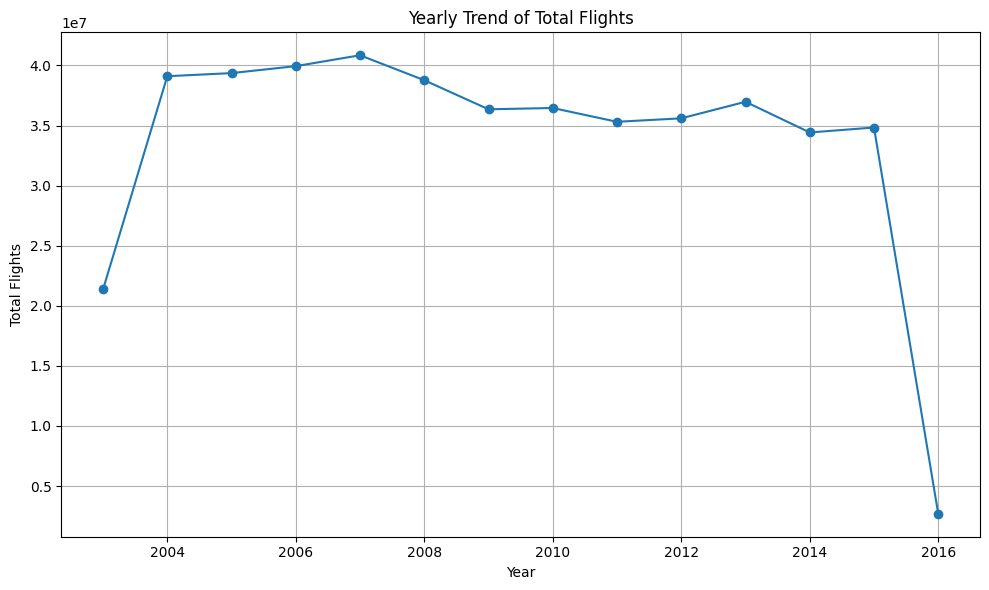

In [16]:
query5= """SELECT t.year, SUM(s.flights_total) AS Total_Flights FROM Time t
    JOIN Statistics s ON t.Label = s.time_label
    GROUP BY t.year
    ORDER BY t.year"""
flight_trends= pd.read_sql(query5,conn)
flight_trends
plt.figure(figsize=(10, 6))
plt.plot(flight_trends['year'], flight_trends['total_flights'],marker='o',linestyle='-')

plt.title('Yearly Trend of Total Flights')
plt.xlabel('Year')
plt.ylabel('Total Flights')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Query 6: Average flights delayed per month over the years

In [17]:
query6 = """SELECT t.Year, t.Month, AVG(s.Flights_Delayed) AS Avg_Delayed_Flights_Per_Month
FROM Time t
JOIN Statistics s ON t.Label = s.Time_Label
GROUP BY t.Year, t.Month
ORDER BY t.Year, t.Month;
"""

avg_delays_df= pd.read_sql(query6, conn)
avg_delays_df

,year,month,avg_delayed_flights_per_month
0,2003,6,1903.448276
1,2003,7,2198.137931
2,2003,8,2285.655172
3,2003,9,1465.965517
4,2003,10,1501.551724
...,...,...,...
147,2015,9,1408.620690
148,2015,10,1390.758621
149,2015,11,1611.034483
150,2015,12,2250.275862


##### Query 7:Airports with highest total minutes of delays including all delay factors

In [26]:
query7 = """SELECT Airport_Code, SUM(Delays_Carrier + Delays_Late_Aircraft + Delays_National_Aviation_System + Delays_Security + Delays_Weather) AS Total_Delayed_Minutes
FROM Statistics
GROUP BY Airport_Code
ORDER BY Total_Delayed_Minutes DESC;"""
time_delays_df=pd.read_sql(query7,conn)
time_delays_df

,airport_code,total_delayed_minutes
0,ATL,9472023
1,ORD,8864694
2,DFW,5918643
3,LAX,4817367
4,DEN,4556142
5,EWR,4379400
6,SFO,4243104
7,IAH,3893517
8,LAS,3428199
9,PHX,3418191


Text(0, 0.5, 'Total Flight delays')

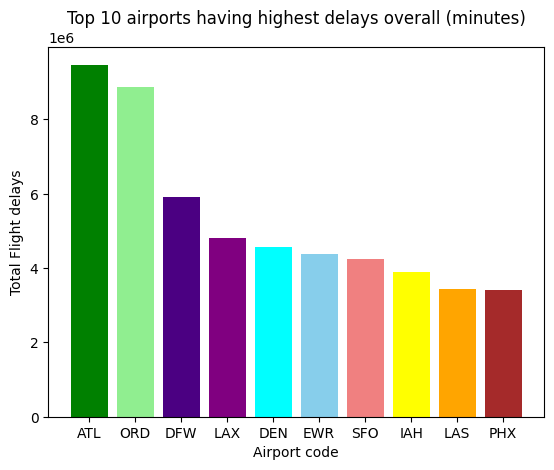

In [44]:
# Top 10 airports with delays by time
time_delays_df=time_delays_df[:10]
colors=["green","lightgreen","indigo","purple","cyan","skyblue","lightcoral","yellow","orange","brown"]
plt.bar(time_delays_df["airport_code"],time_delays_df["total_delayed_minutes"],color=colors)
plt.title('Top 10 airports having highest delays overall (minutes)')
plt.xlabel('Airport code')
plt.ylabel('Total Flight delays')

##### Query 8: Comparison between Airports with highest and lowest no of delayed flight trend over the years

In [45]:
query8="""SELECT a.code as Airport_code,a.name as Airport_name,t.Year,(SUM(s.Flights_Delayed)*1.0 / SUM(s.Flights_Total) * 100) AS Delayed_Flights_Percentage
FROM time t
JOIN statistics s ON t.Label = s.Time_Label
JOIN airports a ON s.Airport_Code = a.Code
WHERE s.Airport_Code IN ('ATL', 'PDX')
GROUP BY t.year,A.CODE
ORDER BY t.Year ;
"""
result_df = pd.read_sql(query8,conn)
pivot_df = result_df.pivot(index='year', columns='airport_code', values='delayed_flights_percentage')
pivot_df

airport_code,ATL,PDX
year,,
2003,19.514149,15.233061
2004,24.902815,18.550886
2005,24.511633,21.323184
2006,26.103120,21.839996
2007,23.425883,22.908210
2008,22.605851,20.996232
2009,25.629043,16.384883
2010,18.787205,15.568397
2011,17.605095,16.377711


In [47]:
#Line plot showing the percentage variation on delays 
traces = []
for airport_code in pivot_df.columns:
    traces.append(go.Scatter(x=pivot_df.index, y=pivot_df[airport_code], mode='lines+markers', name=airport_code))
# Create layout
layout = go.Layout(title='Percentage of Delayed Flights Over Time',
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Percentage of Delayed Flights'))
fig = go.Figure(data=traces, layout=layout)
fig.show()

##### Query 9: Airport with the highest percentage of on-time flights

In [20]:
query9= """SELECT s.Airport_code, (s.flights_on_time * 100.0 / s.flights_total) AS On_Time_Percentage
FROM statistics s
ORDER BY On_Time_Percentage DESC
LIMIT 1;
"""
cursor.execute(query9)
res = cursor.fetchall()[0]
print(f"{res[0]} Airport has the highest percent with {round(float(res[1]),2)}% on-time flights")

SLC Airport has the highest percent with 93.44% on-time flights


##### Query 9: Distribution of carriers variation for each airport

In [21]:
query9="""SELECT Airport_Code,
    AVG(Carriers_Total) AS Avg_Carriers_Total,
    MAX(Carriers_Total) AS Max_Carriers_Total,
    MIN(Carriers_Total) AS Min_Carriers_Total,
    FROM statistics
    GROUP BY Airport_Code
    ORDER BY Airport_Code;
"""
result = pd.read_sql(query9,conn)
result

,airport_code,avg_carriers_total,max_carriers_total,min_carriers_total
0,ATL,13.000000,16,9
1,BOS,13.282895,17,10
2,BWI,12.000000,15,8
3,CLT,11.526316,15,8
4,DCA,13.269737,15,10
5,DEN,13.572368,17,9
6,DFW,13.328947,16,9
7,DTW,13.486842,16,10
8,EWR,12.236842,15,8
9,FLL,10.842105,13,8


In [66]:
query10 = """
SELECT t.year, s.airport_code, SUM(s.Flights_Total) AS Flights_Total
FROM Time t
JOIN Statistics s ON t.label = s.Time_Label
WHERE s.airport_code IN ('ATL', 'BOS')  -- Replace 'ATL' and 'BOS' with the airport codes you want to compare
GROUP BY t.year,s.airport_code
ORDER BY t.year;
"""
cursor.execute(query10)

# Fetch all rows from the result
result = cursor.fetchall()

In [69]:
airport_data = {'ATL': [], 'BOS': []}
for row in result:
    time_label, airport_code, flights_total = row
    airport_data[airport_code].append((time_label, flights_total))

# Plotting the data
# plt.figure(figsize=(10, 6))
# for airport_code, data in airport_data.items():
#     time_labels, total_flights = zip(*data)
#     plt.plot(time_labels, total_flights, label=airport_code)

# plt.xlabel('Time Label')
# plt.ylabel('Total Flights')
# plt.title('Comparison of Total Flights between ATL and BOS')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
fig = go.Figure()

# Add traces for each airport code
for airport_code, data in airport_data.items():
    time_labels, total_flights = zip(*data)
    fig.add_trace(go.Scatter(x=time_labels, y=total_flights, mode='lines+markers', name=airport_code))

fig.update_layout(
    xaxis=dict(title='Time Label', tickangle=45),
    yaxis=dict(title='Total Flights'),
    title='Comparison of Total Flights between ATL and BOS',
    legend=dict(orientation='h', yanchor='top', y=1.15, xanchor='right', x=1)
)
fig.show()

##### Query 11: Diversity of carriers serving each airports

In [60]:
query11="""SELECT 
    Airport_Code,
    (SELECT COUNT(DISTINCT carrier) FROM 
        (SELECT UNNEST(STRING_TO_ARRAY(Carriers_Names, ',')) AS carrier 
         FROM statistics AS s2
         WHERE s2.Airport_Code = s1.Airport_Code) AS carriers) AS Num_Carriers,
         (SELECT STRING_AGG(DISTINCT carrier, ',') FROM 
        (SELECT UNNEST(STRING_TO_ARRAY(Carriers_Names, ',')) AS carrier 
         FROM statistics AS s2
         WHERE s2.Airport_Code = s1.Airport_Code) AS carriers) AS Carrier_List
FROM  
    statistics AS s1
GROUP BY 
    Airport_Code
ORDER BY 
    Num_Carriers DESC;
"""

df=pd.read_sql(query11,conn)
df

,airport_code,num_carriers,carrier_list
0,BOS,25,"AirTran Airways Corporation,Alaska Airlines In..."
1,PHL,25,"AirTran Airways Corporation,Alaska Airlines In..."
2,LGA,24,"AirTran Airways Corporation,American Airlines ..."
3,EWR,24,"AirTran Airways Corporation,Alaska Airlines In..."
4,ATL,24,"AirTran Airways Corporation,Alaska Airlines In..."
5,ORD,24,"Alaska Airlines Inc.,America West Airlines Inc..."
6,LAS,24,"AirTran Airways Corporation,Alaska Airlines In..."
7,DTW,24,"AirTran Airways Corporation,Alaska Airlines In..."
8,DCA,24,"AirTran Airways Corporation,Alaska Airlines In..."
9,BWI,24,"AirTran Airways Corporation,Alaska Airlines In..."
